In [1]:
def get_ytw_from_date(start='1990-01-31', end='2019-07-31', srcfile=r'YTW-All-Values.xlsx'):
    '''
    
    load data from source file into dataframe
    columns:
        Corp - corporate bond rate
        TB - treasury bond rate
        CS - credit spread
        Econ - economic data
    '''
    import pandas as pd
    import cs_logger as cslog

    source_file = srcfile
    src_file = pd.read_excel(source_file, sheet_name='data', header=0, index_col='Date')
    ytw_df = pd.DataFrame(src_file)
    ytw_df = ytw_df.asfreq(pd.infer_freq(ytw_df.index)) # infer data frequency; monthly
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    ytw_df = ytw_df[start_date:end_date]    # filter records by date

    cslog.debug(f"df: {ytw_df.head()}")
    return ytw_df

In [13]:
# does statsmodels.tsa.arima.model ARIMA with exog call VARMAX?
from statsmodels.tsa.statespace.varmax import VARMAX

ytw = get_ytw_from_date(start='2009-01-31', srcfile='YTW-All-Values.xlsx')
print(ytw.shape)
corp, mat = 'Aaa', '3MO'
cs, tb = f'CS-{corp}-{mat}', f'TB-{mat}-TY'
df = ytw[[cs, tb]]

mat = '3MO' # 3MO, 1YR, 5YR
corp = 'Aaa'    # Aaa, Aa, A, Baa

endog = ytw[[f'CS-{corp}-{mat}',f'TB-{mat}-TY']]

# endog = endog.diff(periods=1, axis=0).dropna()  # where stationarity due to first difference

length = int(len(endog) * 0.8)
train, actual = endog[0:length], endog[length:len(endog)] # set training as 80% data. set 20% to actual

# print(f'{actual.head}\n{actual.tail}')
exog = ytw[[f'Market-RMRF']]

order = (3,0)
model_fit = VARMAX(endog=train, order=order, trend='ct').fit() # , exog=exog trendstr{‘n’,’c’,’t’,’ct’} or iterable, optional
print(model_fit.summary())

pre_start, pre_end = '2017-06-30', '2019-07-31'
predict = model_fit.predict(start=pre_start, end=pre_end, exog=exog[length:len(endog)])

# print(predict)

(127, 28)
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
                                Statespace Model Results                               
Dep. Variable:     ['CS-Aaa-3MO', 'TB-3MO-TY']   No. Observations:                  101
Model:                                  VAR(3)   Log Likelihood                 -19.864
                                   + intercept   AIC                             77.728
Date:                         Sat, 29 Aug 2020   BIC                            127.416
Time:                                 18:31:56   HQIC                            97.843
Sample:                             01-31-2009                                         
                                  - 05-31-2017                                         
Covar

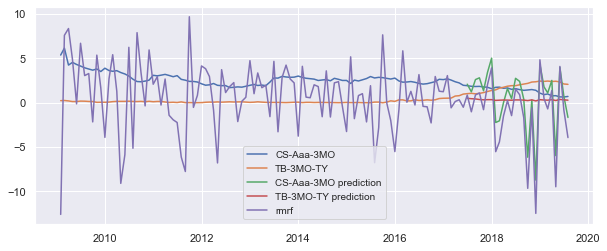

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig = plt.figure(figsize=(10,4))
# fig.suptitle(f'column: {column}')

plt.clf()
# plt.title(column, fontsize=12)
plt.plot(endog)
plt.plot(predict)
plt.plot(exog)
# plt.legend(('train', 'predict', 'actual'), fontsize=10)
plt.legend((cs, tb, f'{cs} prediction', f'{tb} prediction', 'rmrf' ), fontsize=10)